In [ ]:
# activation, gradients, and their statistics

# hockey stick losses -> fixing w2 and b2 (make it less confident)
# dead neuron -> roughly gaussian activation is desired (fixing w1 and b2, scaling down w1 will result in small std of activation)
# how to make roughly gaussian activation
## 1) kaiming init (limitation)
## 2) normalizatino layer: batch normalization

# batch norm
## for roughly gaussian activations, take the activations and normalize (differentiable)
## mean, std through data in a batch -> learn gain, bias (trainable)
## coupling examples -> how to do the inference? two ways (another stage, running mean during the training)
## coupling examples -> normalization effect
## comes after a linear layer -> then what about the bias? bias of a linear layer becomes useless
## torch batchnorm momentum -> when 0.1 (default) can be a problem?


In [112]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
words = open("names.txt").read().splitlines()

a = ord("a")
alps = ["."] + [chr(idx) for idx in range(a, a+26)]

stoi = {s:i for i, s in enumerate(alps)}
itos = {i:s for s, i in stoi.items()}

vocab_size = len(itos)

In [114]:
block_size = 3

def build_dataset(words):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        for ch in list(word) + ["."]:
            label_idx = stoi[ch]
            X.append(context)
            Y.append(label_idx)
            context = context[1:] + [label_idx]
    return torch.tensor(X), torch.tensor(Y)

N = len(words)
random.seed(42)
random.shuffle(words)

tr_idx = int(N * 0.8)
dev_idx = tr_idx + int(N * 0.1)

Xtr, Ytr = build_dataset(words[:tr_idx])
Xdev, Ydev = build_dataset(words[tr_idx:dev_idx])
Xte, Yte = build_dataset(words[dev_idx:])

In [115]:
class Net:
    def __init__(self, emb_size, hidden_size, block_size=3):
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.block_size = block_size
        
        g = torch.Generator().manual_seed(2147483647)
        self.C = torch.randn((27, emb_size), generator=g)
        self.W1 = torch.randn((emb_size * block_size, hidden_size), generator=g) * 0.1
        # self.b1 = torch.randn(hidden_size, generator=g) * 0 
        self.W2 = torch.randn((hidden_size, 27), generator=g) * 0.1
        self.b2 = torch.randn(27, generator=g) * 0

        # batch normalization
        self.bn_gain = torch.ones((1, self.hidden_size))
        self.bn_bias = torch.zeros((1, self.hidden_size))
        self.bn_running_mean = torch.zeros((1, self.hidden_size))
        self.bn_running_std = torch.ones((1, self.hidden_size))
        
        self.parameters = [self.C, self.W1, self.W2, self.b2, self.bn_gain, self.bn_bias] # self.b1,
        for p in self.parameters:
            p.requires_grad = True
        
    def forward(self, X, Y=None, alpha=0, eval=False):
        emb = self.C[X]
        preh = emb.view(-1, self.emb_size * self.block_size) @ self.W1 # + self.b1
        
        # batch normalization
        if not eval:
            bn_mean = torch.mean(preh, dim=0, keepdim=True)
            bn_std = torch.std(preh, dim=0, keepdim=True)
            preh = self.bn_gain * (preh - bn_mean) / bn_std + self.bn_bias
            with torch.no_grad():
                self.bn_running_mean = 0.999 * self.bn_running_mean + 0.001 * bn_mean
                self.bn_running_std = 0.999 * self.bn_running_std + 0.001 * bn_std
        else:
            preh = self.bn_gain * (preh - self.bn_running_mean) / self.bn_running_std + self.bn_bias
            
        h = torch.tanh(preh)
        logits = h @ self.W2 + self.b2
        if Y is not None:
            self.loss = F.cross_entropy(logits, Y) + alpha * ((self.W1**2).mean() + (self.W2**2).mean())
        else:
            self.loss = None
        return logits, self.loss
    
    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()
        
    def update(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

In [116]:
bs = 32
total_iter = 350000

steps = []
losses = []

net = Net(emb_size=16, hidden_size=200, block_size=3)

for itr in range(total_iter):
    batch_ix = torch.randint(low=0, high=Xtr.shape[0], size=(bs,))
    
    _, loss = net.forward(Xtr[batch_ix], Ytr[batch_ix])
    net.backward()
    lr = 0.1 if total_iter < 200000 else 0.01
        
    net.update(lr)
        
    steps.append(itr)
    losses.append(loss.item())
    
with torch.no_grad():
    train_loss = net.forward(Xtr, Ytr)
    dev_loss = net.forward(Xdev, Ydev)
    print(train_loss[1]) # train loss
    print(dev_loss[1]) # dev loss

KeyboardInterrupt: 

### Summary

In [ ]:
class Linear:
    def __init__(self, in_feat, out_feat, bias=True):
        self.W = torch.randn((in_feat, out_feat), generator=g) / in_feat ** 0.5 # kaiming_init
        self.b = torch.zeros(out_feat) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])
        

class BatchNorm1d:
    def __init__(self, num_feat, eps=1e-05, momentum=0.1, training=True):
        self.eps = eps
        self.momentum = momentum
        self.training = training
        # learnable parameters
        self.gamma = torch.ones(num_feat)
        self.beta = torch.zeros(num_feat)
        # buffers
        self.running_mean = torch.zeros(num_feat)
        self.running_var = torch.ones(num_feat)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = xhat * self.gamma + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]
layers = [
    Linear(block_size * n_embd, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]
with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3
            
parameters = [C] + [param for layer in layers for param in layer.parameters()]
total_param = sum(p.nelement() for p in parameters)
print(total_param)
for p in parameters:
  p.requires_grad = True

47024


In [79]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    batch_ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[batch_ix], Ytr[batch_ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    # if i == 10000:
    #     break
    
    break


      0/ 200000: 3.2873


### Tanh activations with 5/3 gain

layer 2 (      Tanh): mean -0.01, std 0.74, saturated: 17.00%
layer 5 (      Tanh): mean -0.01, std 0.69, saturated: 7.56%
layer 8 (      Tanh): mean -0.00, std 0.67, saturated: 6.78%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 5.12%
layer 14 (      Tanh): mean +0.00, std 0.66, saturated: 6.03%


Text(0.5, 1.0, 'activation distribution')

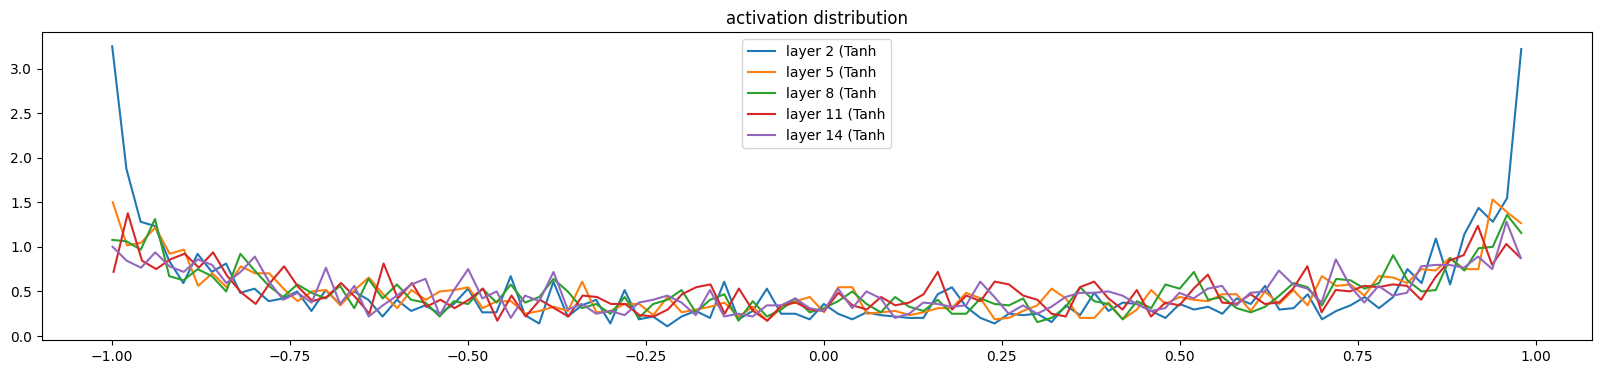

In [80]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Tanh layer is a squashing function. Initial layer will be well-behaved due to the kaiming initialization but Without the 5/3 gain, the rest will slowing shrink to 0. Gain is necessary to fight the squashing effect. If the gain is to big (ex. 3) then saturation will be too high since the activation will be too spread out.

### Tanh layer Gradient

layer 2 (      Tanh): mean -0.000001, std 6.991876e-04
layer 5 (      Tanh): mean -0.000002, std 6.623106e-04
layer 8 (      Tanh): mean -0.000001, std 6.122051e-04
layer 11 (      Tanh): mean -0.000001, std 5.355036e-04
layer 14 (      Tanh): mean +0.000005, std 4.905221e-04


Text(0.5, 1.0, 'gradient distribution')

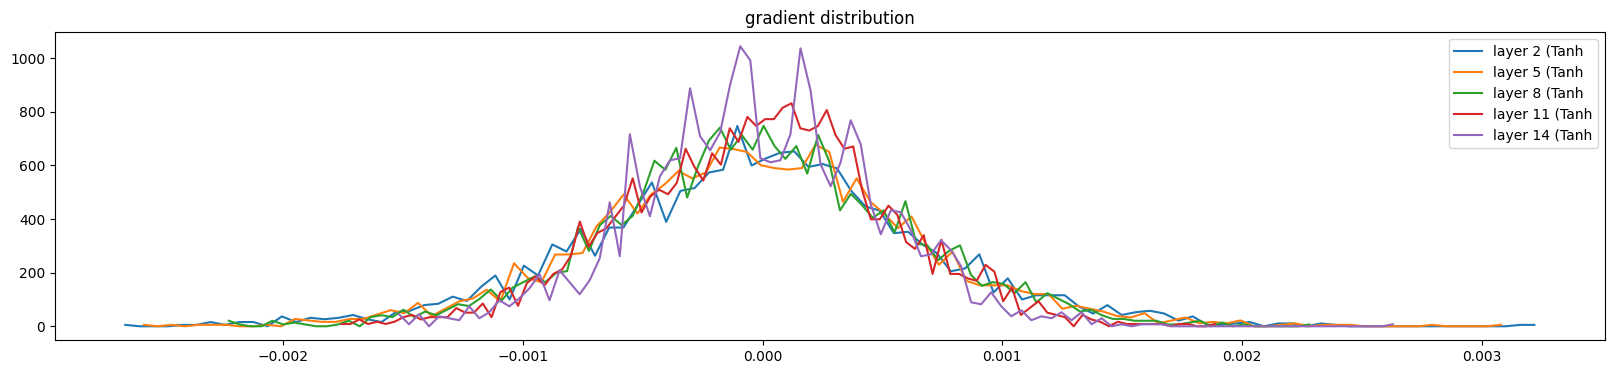

In [81]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

### Linear layer gradient

weight   (27, 10) | mean +0.000009 | std 2.248138e-03 | grad:data ratio 2.246511e-03
weight  (30, 100) | mean -0.000064 | std 2.116986e-03 | grad:data ratio 6.788178e-03
weight (100, 100) | mean +0.000025 | std 1.770754e-03 | grad:data ratio 1.065942e-02
weight (100, 100) | mean -0.000013 | std 1.657112e-03 | grad:data ratio 9.870586e-03
weight (100, 100) | mean -0.000011 | std 1.503743e-03 | grad:data ratio 8.994667e-03
weight (100, 100) | mean -0.000002 | std 1.266396e-03 | grad:data ratio 7.567621e-03
weight  (100, 27) | mean +0.000000 | std 2.205601e-03 | grad:data ratio 1.338468e-02


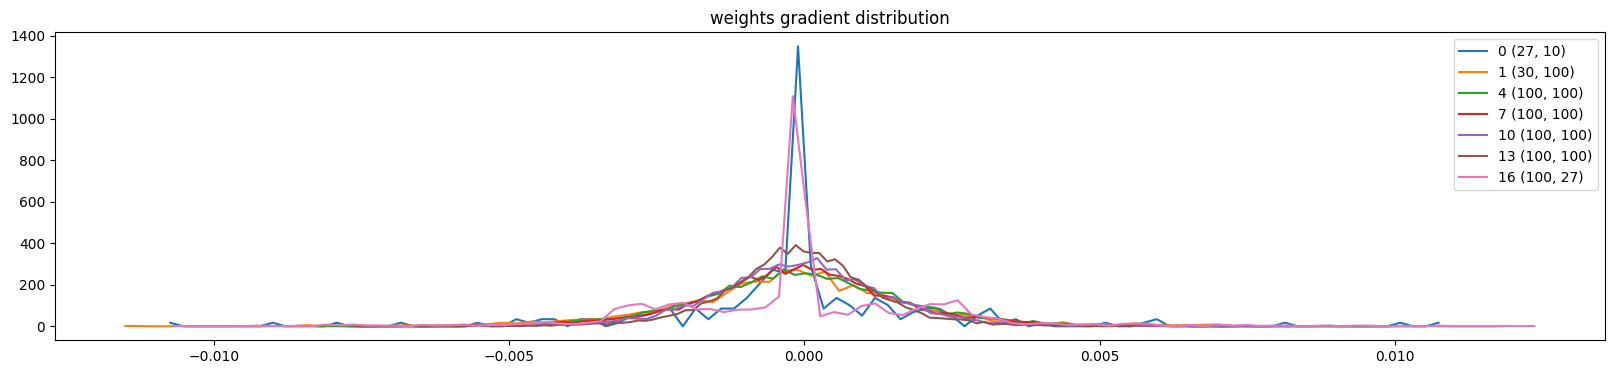

In [46]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

### update:data ratio over time

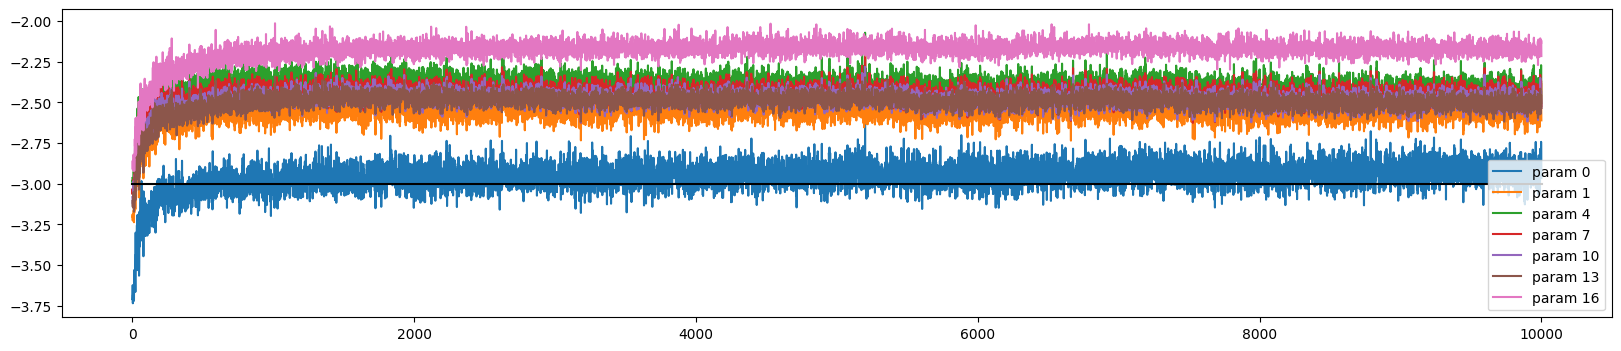

In [49]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

### E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [ ]:
class Linear:
    def __init__(self, in_feat, out_feat, bias=True):
        # self.W = torch.randn((in_feat, out_feat), generator=g) / in_feat ** 0.5 # kaiming_init
        self.W = torch.zeros((in_feat, out_feat))
        self.b = torch.zeros(out_feat) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])
        

class BatchNorm1d:
    def __init__(self, num_feat, eps=1e-05, momentum=0.1, training=True):
        self.eps = eps
        self.momentum = momentum
        self.training = training
        # learnable parameters
        self.gamma = torch.ones(num_feat)
        self.beta = torch.zeros(num_feat)
        # buffers
        self.running_mean = torch.zeros(num_feat)
        self.running_var = torch.ones(num_feat)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = xhat * self.gamma + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]
layers = [
    Linear(block_size * n_embd, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]
with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3
            
parameters = [C] + [param for layer in layers for param in layer.parameters()]
total_param = sum(p.nelement() for p in parameters)
print(total_param)
for p in parameters:
  p.requires_grad = True

47024


In [67]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    batch_ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[batch_ix], Ytr[batch_ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    # if i == 10000:
    #     break


      0/ 200000: 3.2958
  10000/ 200000: 2.7882
  20000/ 200000: 2.7518
  30000/ 200000: 2.8506
  40000/ 200000: 2.8221
  50000/ 200000: 2.8987
  60000/ 200000: 2.6038
  70000/ 200000: 2.6751
  80000/ 200000: 3.0131
  90000/ 200000: 2.7753
 100000/ 200000: 2.6079
 110000/ 200000: 2.5273
 120000/ 200000: 2.6690
 130000/ 200000: 2.6426
 140000/ 200000: 2.8423
 150000/ 200000: 2.5484
 160000/ 200000: 2.9788
 170000/ 200000: 2.9535
 180000/ 200000: 2.8622
 190000/ 200000: 2.8513


layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

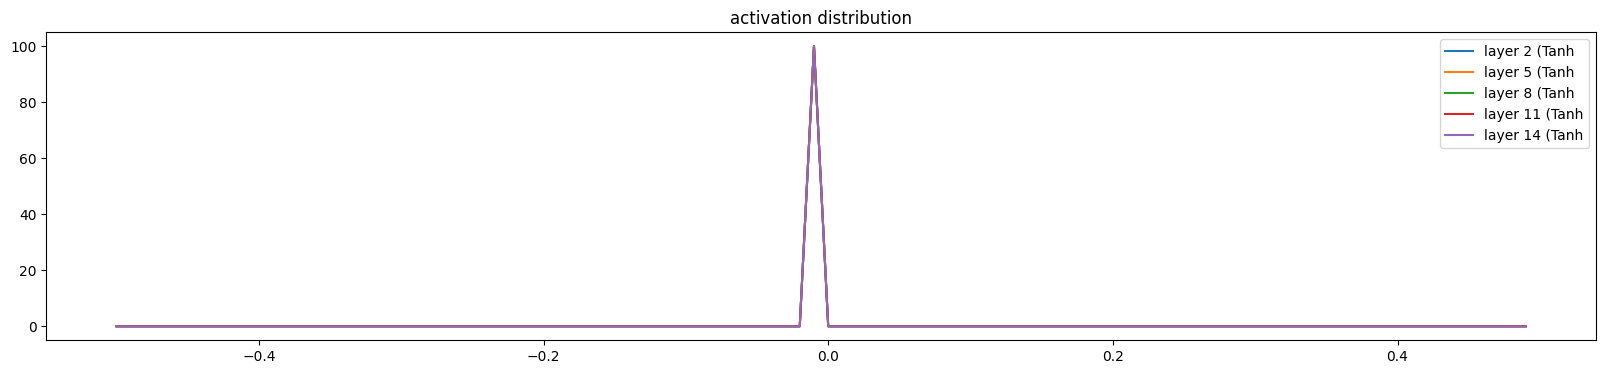

In [68]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

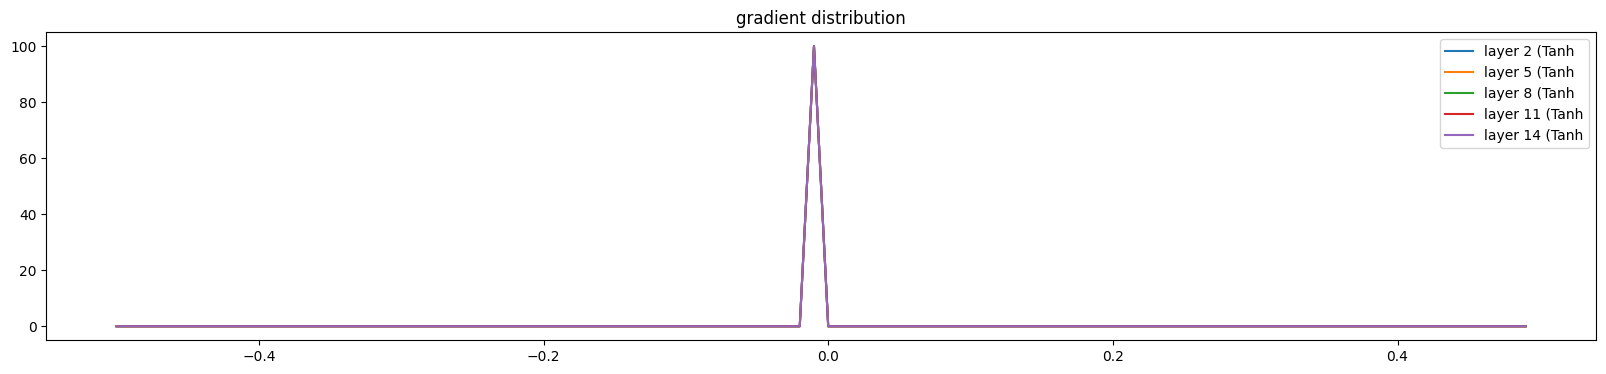

In [55]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


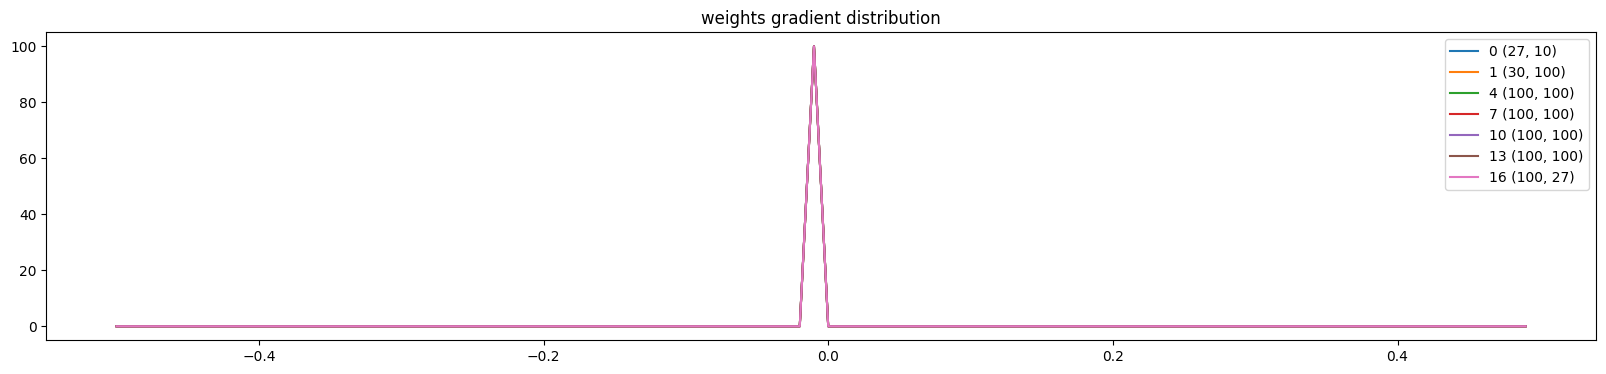

In [69]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

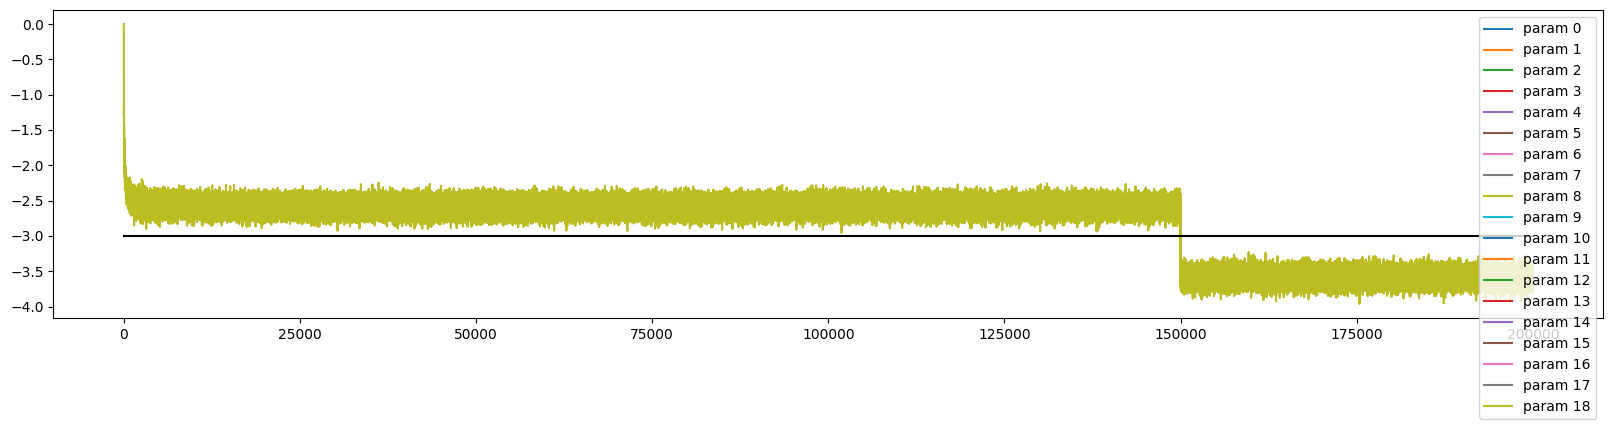

In [71]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  # if p.ndim == 2:
  plt.plot([ud[j][i] for j in range(len(ud))])
  legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

Only the last BN layer's bias gets train from the gradient from the loss.

### E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [ ]:
class Linear:
    def __init__(self, in_feat, out_feat, bias=True):
        self.W = torch.randn((in_feat, out_feat), generator=g) / in_feat ** 0.5 # kaiming_init
        self.b = torch.zeros(out_feat) if bias else None
        
    def __call__(self, x, W2=None, b2=None):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        if W2 is not None and b2 is not None:
            # print(f"x shape: {self.out.shape}")
            # print(f"W shape: {W2.shape}")
            # print(f"b2 shape: {b2.shape}")
            # print(f"self.out * W2 shape: {(self.out * W2).shape}")
            self.out = self.out * W2 + b2
        return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])
        

class BatchNorm1d:
    def __init__(self, num_feat, eps=1e-05, momentum=0.1, training=True):
        self.eps = eps
        self.momentum = momentum
        self.training = training
        # learnable parameters
        self.gamma = torch.ones(num_feat)
        self.beta = torch.zeros(num_feat)
        # buffers
        self.running_mean = torch.zeros(num_feat)
        self.running_var = torch.ones(num_feat)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = xhat * self.gamma + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(block_size * n_embd, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]
with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3
            
parameters = [C] + [param for layer in layers for param in layer.parameters()]
total_param = sum(p.nelement() for p in parameters)
print(total_param)
for p in parameters:
  p.requires_grad = True

16424


In [153]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    batch_ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[batch_ix], Ytr[batch_ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    if i == 10000:
        break

      0/ 200000: 2.1272
  10000/ 200000: 2.3736


In [154]:
# train loss, eval loss
with torch.no_grad():
    emb = C[Xtr]
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    train_loss = F.cross_entropy(x, Ytr)
print(f"train loss: {train_loss.item()}")

with torch.no_grad():
    emb = C[Xdev]
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False
        x = layer(x)
    dev_loss = F.cross_entropy(x, Ydev)
print(f"dev loss: {dev_loss.item()}")

train loss: 2.154330253601074
dev loss: 2.1759791374206543


In [155]:
# create new_layers without batch norm

# xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
# self.out = xhat * self.gamma + self.beta
# out = self.gamma  / torch.sqrt(xvar + self.eps) * x - self.gamma (xmean / torch.sqrt(xvar + self.eps)) + self.beta
#       -----------------------------------------     --------------------------------------------------------------
#                       W2                                                        b2

def inference_with_folded_network(X, Y):
    layers_wo_bn = []

    with torch.no_grad():
        emb = C[X]
        x = emb.view(-1, block_size * n_embd)
        i = 0
        while i < len(layers):
            layer = layers[i]
            if isinstance(layer, Linear):
                next_layer = layers[i+1]
                assert isinstance(next_layer, BatchNorm1d)
                
                W2 = next_layer.gamma / torch.sqrt(next_layer.running_var + next_layer.eps)
                # print(W2.shape)
                b2 = -next_layer.gamma * (next_layer.running_mean / torch.sqrt(next_layer.running_var + next_layer.eps)) + next_layer.beta
                # print(b2.shape)
                # print(x.shape)
                x = layer(x, W2, b2)
                layers_wo_bn.append(layer)
                i += 2
            else:
                x = layer(x)
                layers_wo_bn.append(layer)
                i += 1
        loss = F.cross_entropy(x, Y)
    return layers_wo_bn, loss

layers_wo_bn, train_loss = inference_with_folded_network(Xtr, Ytr)
print(f"train loss: {train_loss.item()}")
_, dev_loss = inference_with_folded_network(Xdev, Ydev)
print(f"dev loss: {dev_loss.item()}")

train loss: 2.154330253601074
dev loss: 2.1759791374206543
